In [1]:
import os
import re
import glob
import pandas as pd
import csv
from sklearn.cross_decomposition import CCA
from sklearn.utils import resample
from sklearn.utils import shuffle
import load_approved_data
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import matplotlib.ticker as ticker

c:\users\grace\appdata\local\programs\python\python36\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory c:\users\grace\appdata\local\programs\python\python36\lib\site-packages\google: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
c:\users\grace\appdata\local\programs\python\python36\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory c:\users\grace\appdata\local\programs\python\python36\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
bootstrap_iters = 5
n_cca_components = 52

In [4]:
#read in other demographic data to pandas dataframe
demographics_data_filename = r'Project\data\original\ukb46307_with_civet_reduced.tab'
#approved_col_list = ['CCID', 'homeint_handedness', 'additional_qual','homeint_v349']

demographics_data = pd.read_csv(demographics_data_filename, header=0,  index_col='f.eid', sep='\t')
#approved_data = load_approved_data.load_approved_data(approved_data_filename)

In [5]:
all_ids = demographics_data.index.tolist()
print("Participants: " + str(len(all_ids)))

Participants: 26508


In [6]:
demographics_data = demographics_data.drop(columns=['countnull'])

In [7]:
#demographics_data.columns[demographics_data.isna().any()].tolist()

In [8]:
#print(demographics_data['f.1011.2.0'].value_counts())
#demographics_data['f.1011.2.0'] = demographics_data['f.1011.2.0'].addcategory('-1000.0').fillna('-1000.0')
#print(demographics_data['f.1011.2.0'].value_counts())

In [9]:
demo_cols = demographics_data.columns

In [11]:
col_name_dict_file = r'Project/data/supplemental/ColumnHeaders-WrittenNames-Shortform.csv'
col_readable_name_dict = pd.read_csv(col_name_dict_file, header=None, index_col=0, squeeze=True).to_dict()

In [12]:
demo_cols_categorical = ['f.31.0.0','f.971.2.0', 'f.981.2.0', 'f.991.2.0', 'f.1001.2.0', 'f.1011.2.0', 'f.1021.2.0', 'f.1031.2.0', 'f.1249.2.0', 'f.1259.2.0', 'f.2634.2.0', 'f.3393.2.0', 'f.3637.2.0', 'f.3647.2.0', 'f.4792.2.0', 'f.4803.2.0', 'f.6160.2.1', 'f.6160.2.2', 'f.6160.2.3', 'f.6160.2.4', 'f.20160.2.0']
for col_name in  demo_cols:
    if col_name in demo_cols_categorical:
        #change column type to category
        demographics_data[col_name] = demographics_data[col_name].astype('category')
        if 0 in demographics_data[col_name].cat.categories:
            if -1 in demographics_data[col_name].cat.categories:
                demographics_data[col_name] = demographics_data[col_name].cat.add_categories('-1.0').fillna('-1.0')
            else:
                demographics_data[col_name] = demographics_data[col_name].cat.add_categories('-4.0').fillna('-4.0')
        else:
            demographics_data[col_name] = demographics_data[col_name].cat.add_categories('0').fillna('0')
        #add category to encompass nulls
        #demographics_data[col_name] = demographics_data[col_name].cat.add_categories('-1.0').fillna('-1.0')
    else:
        demographics_data[col_name] = demographics_data[col_name].fillna(demographics_data[col_name].mean())
        demographics_data[col_name] = zscore(demographics_data[col_name])

In [13]:
demographics_data = demographics_data.fillna(demographics_data.mean())

In [14]:
#read in pca of vertices
component_file_location = r'F:valid//all_600_pcas_vertex.csv'
vertexes_data = pd.read_csv(component_file_location, header=None, index_col=0)#.transpose()

In [15]:
vert_cols = vertexes_data.columns

In [16]:
print(vertexes_data.shape)
print(demographics_data.shape)

(25043, 600)
(26508, 52)


In [17]:
demographics_data = pd.merge(vertexes_data,demographics_data,how="inner",left_index=True,right_index=True)[demo_cols]

In [18]:
vertexes_data.sort_index(inplace=True, ascending=True)
demographics_data.sort_index(inplace=True, ascending=True)

In [19]:
print(vertexes_data.shape)
print(demographics_data.shape)

(25043, 600)
(25043, 52)


In [18]:
#demographics_data.isna().sum().sum()

In [19]:
#print(vertexes_data.head)
#print(demographics_data.head)

In [20]:
cca_model = CCA(n_components=52)
cca_model.fit(demographics_data,vertexes_data)
demographics_data_T, vertexes_data_T = cca_model.transform(demographics_data,vertexes_data)
print(demographics_data_T.shape)
print(vertexes_data_T.shape)
result = np.corrcoef(demographics_data_T.T, vertexes_data_T.T).diagonal(offset=cca_model.n_components)
cc_corr = np.corrcoef(cca_model.x_scores_, rowvar=False).diagonal(offset=cca_model.n_components)

(25043, 52)
(25043, 52)


In [21]:
#print(X_weights[0,:].shape)
#print(Y_weights[0,:].shape)
#cc_corr = np.corrcoef(demographics_data_T[:,0],vertexes_data_T[:,0])
#cc_corr = np.corrcoef(X_loadings,Y_loadings,rowvar=False).diagonal(offset=cca_model.n_components)
#print(cc_corr)
#print(len(cc_corr))
#print(result)

Text(0.5, 1.0, 'Canonical correlations')

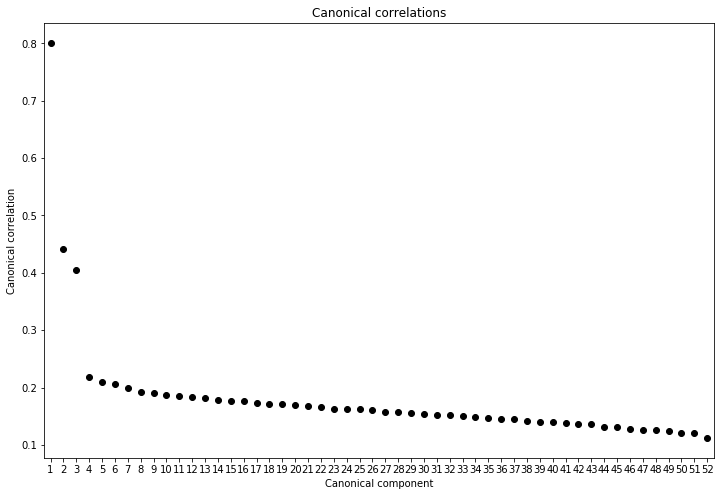

In [21]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(np.arange(cca_model.n_components)+1, result, 'ko')
plt.xlim(.5, .5+cca_model.n_components)
plt.xticks(np.arange(cca_model.n_components)+1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')

In [23]:
#X = cca_model.predict(demographics)
X_weights = cca_model.x_weights_
X_loadings = cca_model.x_loadings_
Y_weights = cca_model.y_weights_
Y_loadings = cca_model.y_loadings_
coefficients = cca_model.coef_

my_coef_counts = dict()
my_x_loadings = dict()
for x_load in X_loadings.transpose():
    #print(x_load)
    my_x_loadings[repr(x_load)] = 1
for coef in coefficients:
    #print(coef.shape)
    #Note: use repr to convert coef to string since can't hash numpy array
    my_coef_counts[repr(coef)] = 1 

In [24]:
x_loading_fileout = r'Project\data\cca_model_demographic_loadings.csv'
with open(x_loading_fileout, 'w') as f:
    cwriter = csv.writer(f, delimiter=',', lineterminator='\n')
    cwriter.writerows(X_loadings)

In [25]:
y_loading_fileout = r'Project\data\cca_model_vertex_loadings.csv'
with open(y_loading_fileout, 'w') as f:
    cwriter = csv.writer(f, delimiter=',', lineterminator='\n')
    cwriter.writerows(Y_loadings)

In [26]:
#cca_model_shuffled = CCA(n_components=52)
#demographics_shuffled, vertexes_shuffled = shuffle(demographics_data, vertexes_data, random_state=b_iter)
#cca_model_shuffled.fit(demographics_data, vertexes_shuffled)
#test1_c, test2_c = cca_model_shuffled.transform(demographics_shuffled, vertexes_shuffled)
#testcorrs = np.corrcoef(test1_c.T, test2_c.T).diagonal(offset=cca_model_shuffled.n_components)
#corrcoefs_bstrap[:,b_iter] = testcorrs

In [22]:
corrcoefs_bstrap = np.zeros((n_cca_components, bootstrap_iters))
print(corrcoefs_bstrap.shape)
fwe_vals = np.zeros((n_cca_components,1))
count_bins=np.zeros(10)

(52, 5)


In [25]:
corrcoefs_bstrap_ls = []

In [26]:
def run_shuffled_cca(ddata,vdata, ix):
    demographics_shuffled, vertexes_shuffled = shuffle(ddata, vdata, random_state=ix)
    #vertexes_shuffled = shuffle(vertexes)
    cca_model_shuffled = CCA(n_components=n_cca_components)
    cca_model_shuffled.fit(ddata,vertexes_shuffled)
    #coefficients_temp = cca_model_shuffled.coef_
    #X_loadings_temp = cca_model_shuffled.x_loadings_
    #Y_loadings_temp = cca_model_shuffled.y_loadings_
    test1_c, test2_c = cca_model_shuffled.transform(ddata, vertexes_shuffled)
    testcorrs = np.corrcoef(test1_c.T, test2_c.T).diagonal(offset=cca_model_shuffled.n_components)
    return testcorrs

In [27]:
print(time.ctime(time.time()))
for b_iter in range(0,bootstrap_iters):
    #corrcoefs_bstrap[:,b_iter] = run_shuffled_cca(demographics_data,vertexes_data)
    corrcoefs_bstrap_ls.append(run_shuffled_cca(demographics_data,vertexes_data,b_iter))
    """
    for testcorrs_element in testcorrs:
        #print(testcorrs_element)
        bin_val = int(abs((testcorrs_element*100))) // 10
        count_bins[bin_val] = count_bins[bin_val] + 1
    for coef in coefficients_temp:
        coef_hashable = repr(coef)
        if coef_hashable in my_coef_counts:
            my_coef_counts[coef_hashable] += 1
        else:
            my_coef_counts[coef_hashable] = 1
    for x_load in X_loadings_temp.transpose():
        x_load_hashable = repr(x_load)
        if x_load_hashable in my_x_loadings:
            my_x_loadings[x_load_hashable] += 1
        else:
            my_x_loadings[x_load_hashable] = 1
    """
    if b_iter % 10 == 0:
        print(str(b_iter) + " at " + time.ctime(time.time()))
        

        print(time.time())

Fri Apr  8 11:26:11 2022
0 at Fri Apr  8 11:36:05 2022
1649432165.0888963


In [153]:
print(len(np.array(corrcoefs_bstrap_ls).mean(axis=0)))
print(corrcoefs_bstrap_ls[1].mean())

52
0.15326558055060774


In [35]:
corrcoefs_bstrap = np.array(corrcoefs_bstrap_ls)
corrcoefs_bstrap_means = corrcoefs_bstrap.mean(axis=0)
corrcoefs_bstrap_5p = np.percentile(corrcoefs_bstrap, 5, axis=0)
corrcoefs_bstrap_95p = np.percentile(corrcoefs_bstrap, 95, axis=0)

In [38]:
corrcoefs_bstrap_fileout = r'Project\data\corrcoefs_bstrap.csv'
with open(corrcoefs_bstrap_fileout, 'w') as f:
    cwriter = csv.writer(f, delimiter=',', lineterminator='\n')
    cwriter.writerows(corrcoefs_bstrap)

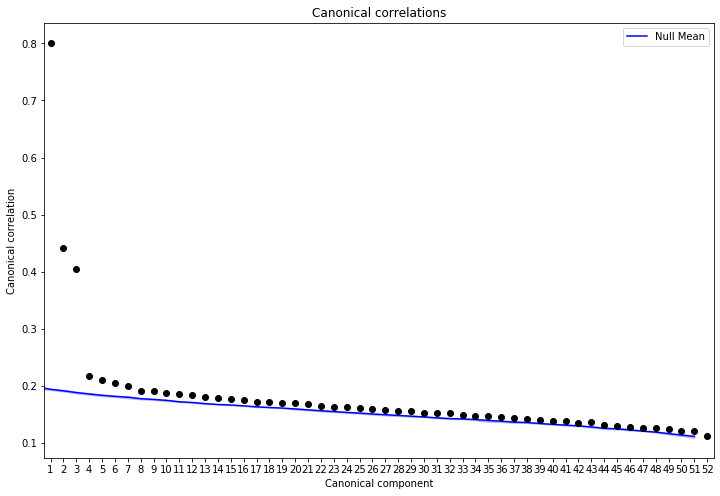

In [36]:
x = np.arange(len(corrcoefs_bstrap_means))
plt.plot(x, corrcoefs_bstrap_means, 'b-', label='Null Mean')
plt.fill_between(x, corrcoefs_bstrap_5p, corrcoefs_bstrap_95p, color='b', alpha=0.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(np.arange(cca_model.n_components)+1, result, 'ko')
plt.xlim(.5, .5+cca_model.n_components)
plt.xticks(np.arange(cca_model.n_components)+1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')
plt.legend()
plt.show()

In [36]:
for comp_x in range(0,n_cca_components):
    corr_x = result[comp_x]
    temp_compare = np.zeros(bootstrap_iters)
    for b_iter in range(0,bootstrap_iters):
        if corr_x < corrcoefs_bstrap[0,b_iter]:
            temp_compare[b_iter] = 1
        else:
            temp_compare[b_iter] = 0
    fwe_vals[comp_x] = (1+sum(temp_compare))/bootstrap_iters
    #print(temp_compare)
    #print(corr_x, fwe_vals[comp_x])
#print(fwe_vals)

0.19896278181247912 [0.3]
0.19247878600746648 [1.]
0.18968346922392285 [1.01]
0.18877419561365866 [1.01]
0.18659460423816432 [1.01]
0.18327549418148015 [1.01]
0.18140398289005322 [1.01]
0.18055091690434358 [1.01]
0.1787214040043291 [1.01]
0.17721784211083946 [1.01]
0.17542701415985545 [1.01]
0.17314684576800912 [1.01]
0.1717090110802715 [1.01]
0.1707449500436018 [1.01]
0.1700584694429782 [1.01]
0.16881181392421396 [1.01]
0.16657584086850388 [1.01]
0.16447971082695725 [1.01]
0.16387313589120825 [1.01]
0.16287590415065212 [1.01]
0.16164201836699896 [1.01]
0.1603280429244418 [1.01]
0.16020846223402377 [1.01]
0.15668163667490936 [1.01]
0.15583455160326715 [1.01]
0.15365323752227447 [1.01]
0.15219031041661168 [1.01]
0.14977263027399015 [1.01]
0.14823585941814565 [1.01]
0.1460876281863459 [1.01]
0.14548023309750763 [1.01]
0.1449756702787238 [1.01]
0.14330239746149206 [1.01]
0.14143301854863352 [1.01]
0.1396203214014597 [1.01]
0.1382539351236964 [1.01]
0.13700619900419383 [1.01]
0.13564349291

In [26]:
demo_col_readable_name = [col_readable_name_dict.get(item,item)  for item in demo_cols]
print(demo_col_readable_name)

['Sex', 'Education', 'Walk Amnt', 'Walk Time', 'Moderate PA Amnt', 'Moderate PA Time', 'Hard PA  Amnt', 'Hard PA Time', 'Stairs Amnt', 'Fun Walk Amnt', 'Fun Walk Time', 'Sport Amnt', 'Sport Time', 'DIY Amnt', 'DIY Duration', 'Friend/Family', 'Curr Tobacco', 'Past Tobacco', 'Smokers in home', 'Smoke in home', 'Smoke outside', 'Alc Intake', 'Dep Mood', 'Confidants', 'Hearing', 'Diabetes', 'Hard DIY Amnt', 'Hard DIY Time', 'High BP', 'Hearing Aid', 'Num Cigs', 'Other exercise Amnt', 'Other exercise Time', 'Work Fulfil', 'Health Fulfil', 'Family Fulfil', 'Friend Fulfil', 'Cochlear', 'Tinnitus', 'Social Activity 1', 'Social Activity 2', 'Social Activity 3', 'Social Activity 4', 'Social Activity 5', 'Smoker', 'Major Depress Single', 'Major Depress Temp', 'Major Depress Recur', 'Past Smoker', 'BMI', 'BP 1', 'BP 2']


In [78]:
weighted_pca_columns = pd.DataFrame({'Col':vert_cols,'Weight':Y_loadings[:,1],'Abs Weight':abs(Y_loadings[:,1])})
weighted_pca100_columns = pd.DataFrame({'Col':vert_cols[:100],'Weight':Y_loadings[:100,1],'Abs Weight':abs(Y_loadings[:100,1])})

In [52]:
weighted_pca_columns.head

<bound method NDFrame.head of      Col    Weight  Abs Weight
0      1 -0.186790    0.186790
1      2 -0.336076    0.336076
2      3  0.304762    0.304762
3      4 -0.202304    0.202304
4      5 -0.349195    0.349195
..   ...       ...         ...
595  596  0.013735    0.013735
596  597 -0.018553    0.018553
597  598 -0.005086    0.005086
598  599 -0.003062    0.003062
599  600  0.007619    0.007619

[600 rows x 3 columns]>

In [48]:
weighted_columns = pd.DataFrame({'Col':demo_cols,'Weight':X_loadings[:,1],'Abs Weight':abs(X_loadings[:,1])})
#demo_col_readable_name = [col_readable_name_dict.get(item,item)  for item in demo_cols]
weighted_columns = weighted_columns.replace({'Col': col_readable_name_dict})
#print(weighted_columns)

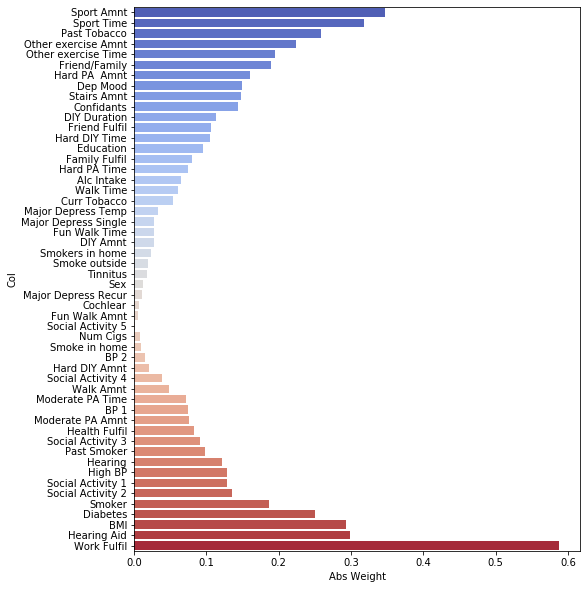

In [73]:
plt.figure(figsize=(8,10))
sns.barplot(x='Abs Weight', y='Col',data=weighted_columns, order=weighted_columns.sort_values('Weight').Col, ci=None, palette='coolwarm')

In [169]:
custom_palette = {}
for q in set(weighted_pca_columns.Col):
    w = weighted_pca_columns.loc[weighted_pca_columns['Col'] == q, 'Weight'].iloc[0]
    if w < 0:
        custom_palette[q] = 'b'
    else:
        custom_palette[q] = 'r'

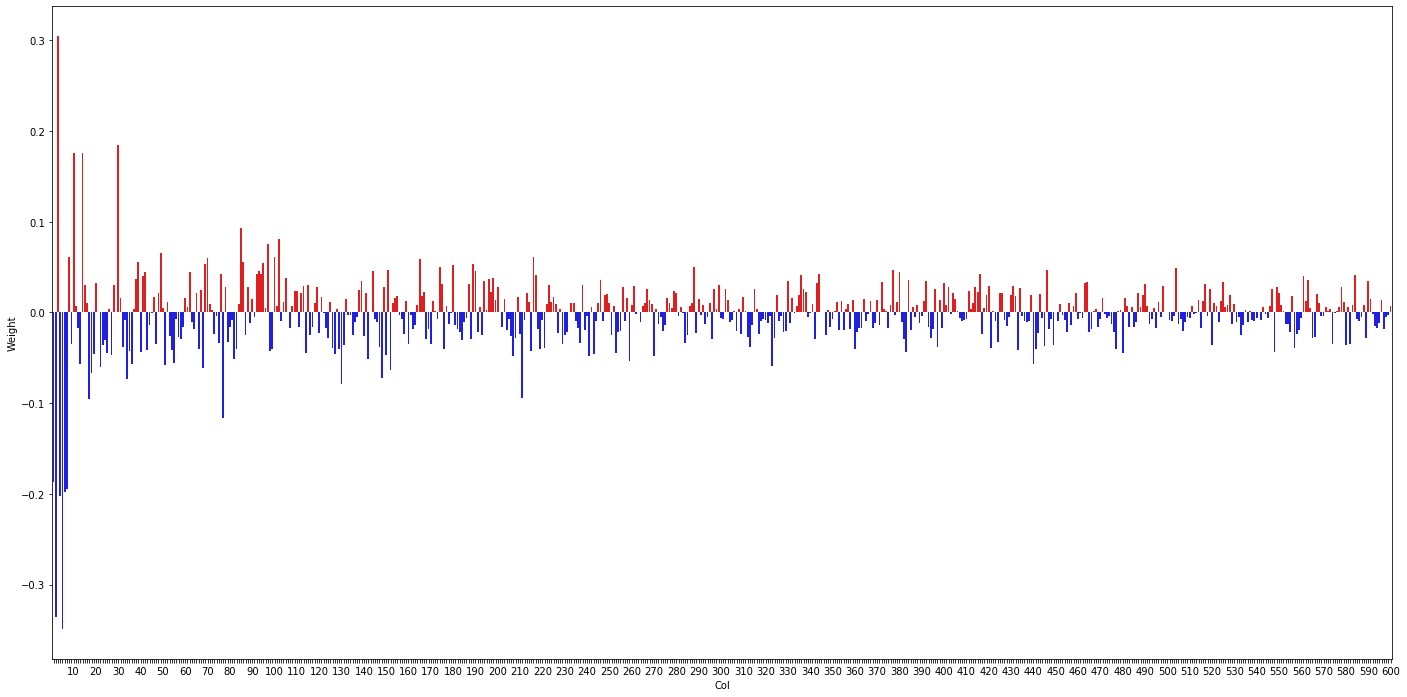

In [170]:
plt.figure(figsize=(24,12))
plot_ = sns.barplot(y='Weight', x='Col', data=weighted_pca_columns, ci=None, palette=custom_palette)
#plot_.xaxis.set_major_locator(ticker.LinearLocator(600))
for ind, label in enumerate(plot_.get_xticklabels()):
    if (ind+1) % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)